In [0]:
# import libraries
from keras.callbacks import ModelCheckpoint
from keras.models import Model, load_model, Sequential
from keras.layers import Dense, Activation, Dropout, Input, Masking, TimeDistributed, LSTM, Conv1D
from keras.layers import GRU, Bidirectional, BatchNormalization, Reshape
from keras.optimizers import Adam
from keras.layers import CuDNNLSTM, LeakyReLU

from matplotlib import pyplot as plt

import pandas as pd
import numpy as np
from keras.preprocessing.sequence import pad_sequences

In [0]:
# parameters
NUM_SIGNALS = 30
AUG_MUL = 5
NUM_TRAINING_SIGNALS = 24
NUM_DEV_SIGNALS = NUM_SIGNALS - NUM_TRAINING_SIGNALS
NUM_FILTERS = 128
FILTER_SIZE = 16
STRIDE = 4
DROPOUT = 0.6
Tx = 7657
NOISE_MEAN = 0
NOISE_VAR = 10
NOISE_MAX = 100
NOISE_NORM_CONST = 1000
OFFSET = [0, 256, 512, 1024, 2048]
Ty = int((Tx - FILTER_SIZE)/STRIDE) + 1

# read labels from GT.csv
df_y = pd.read_csv("GT.csv")
Y_temp1 = []   # list of labels for even locations
Y_temp2 = []   # list of labels for odd locations

X = []   # list of features   
Y_final = np.array(df_y)

for i in range(NUM_SIGNALS):
                                                                # -- FEATURES --
  loc_i = df_y.iloc[:, i]
  loc_i = np.array(loc_i)   # locations of trigger points in ith signal
  
  s_i = np.array(pd.read_csv("s{}.csv".format(i+1)))  # load ith signal
  X.append(s_i)
                                                                  # -- LABELS --
  l = s_i.size  # length of ith signal
  
  label_i1 = np.zeros(l)   # this will contain the even labels
  label_i2 = np.zeros(l)   # this will contain the odd labels
  
  for j in range(np.size(loc_i)):
    for k in range(loc_i[j]-50, loc_i[j]+51):
      if j % 2 == 0:
        label_i1[k] = 1
      else:
        label_i2[k] = 1
  
  label_i1 = label_i1.reshape(-1, 1)
  label_i2 = label_i2.reshape(-1, 1)
  Y_temp1.append(label_i1)
  Y_temp2.append(label_i2)

# padding to equalise lengths of all signals    
Y_temp1 = pad_sequences(Y_temp1, padding = 'post', dtype = 'float32')
Y_temp2 = pad_sequences(Y_temp2, padding = 'post', dtype = 'float32')
X = pad_sequences(X, dtype = 'float32', padding = 'post')
                                                                  ##############
def data_aug(X_train, Y_train1, Y_train2, add_noise):
    # Augment features
    X_train_aug = []

    for i in range(np.shape(X_train)[0]):
      for j in range (AUG_MUL):   # shift right
        offset = OFFSET[j]
        s_i = X_train[i]
        s_temp = np.zeros(np.shape(s_i))
    
        for k in range(np.size(s_temp)):
          if offset + k < np.size(s_temp):
            s_temp[offset + k] = s_i[k]
            r = np.maximum(NOISE_MAX, np.random.normal(NOISE_MEAN, NOISE_VAR))/NOISE_NORM_CONST
            if j != 0 and add_noise == True:
              s_temp[offset + k] += r
            
        X_train_aug.append(s_temp)
    
        s_temp = np.zeros(np.shape(s_i))   # shift left
    
        for k in range(np.size(s_temp)):
          if offset + k < np.size(s_i):
            s_temp[k] = s_i[k + offset]
            r = np.maximum(NOISE_MAX, np.random.normal(NOISE_MEAN, NOISE_VAR))/NOISE_NORM_CONST
            if j != 0 and add_noise == True:
              s_temp[offset + k] += r
        
        X_train_aug.append(s_temp)

    # Augment labels
    Y_train_aug_1 = []
    Y_train_aug_2 = []
    
    for i in range(np.shape(Y_train1)[0]):
      for j in range (AUG_MUL):   # shift right
        offset = OFFSET[j]
        label_i1 = Y_train1[i]
        label_i2 = Y_train2[i]
        label_temp1 = np.zeros(np.shape(label_i1))    
        label_temp2 = np.zeros(np.shape(label_i2))    
    
        for k in range(np.size(label_i1)):
          if offset + k < np.size(label_i1):
            label_temp1[k + offset] = label_i1[k]
    
        for k in range(np.size(label_i2)):
          if offset + k < np.size(label_i2):
            label_temp2[k + offset] = label_i2[k]
    
        Y_train_aug_1.append(label_temp1)
        Y_train_aug_2.append(label_temp2)

        offset = OFFSET[j]
        label_i1 = Y_train1[i]
        label_i2 = Y_train2[i]
        label_temp1 = np.zeros(np.shape(label_i1))    
        label_temp2 = np.zeros(np.shape(label_i2))    
    
        for k in range(np.size(label_i1)):
          if offset + k < np.size(label_i1):
            label_temp1[k] = label_i1[k + offset]
    
        for k in range(np.size(label_i2)):
          if offset + k < np.size(label_i2):
            label_temp2[k] = label_i2[k + offset]
    
        Y_train_aug_1.append(label_temp1)
        Y_train_aug_2.append(label_temp2)

    return X_train_aug, Y_train_aug_1, Y_train_aug_2
                                                                ################
def scale_down(Y):   # Scale down the labels to match the size of the network's output
  Ty = int((Tx - FILTER_SIZE)/STRIDE) + 1   # size of output of the network
  Y_out = []

  for i in range(np.shape(Y)[0]):
    A = np.zeros((Ty, 1))
    for j in range(np.size(Y[i])):
      if (Y[i])[j] == 1:
        index = int(j*Ty/Tx)
        A[index] = 1
    Y_out.append(A)
   
  return Y_out

In [0]:
def split(X, Y_temp1, Y_temp2, Y_final):
  # Split the data into traininng set and dev set
  X_train = np.array(X[0:NUM_TRAINING_SIGNALS])
  X_dev = np.array(X[NUM_TRAINING_SIGNALS:])
  Y_final_dev = Y_final[NUM_TRAINING_SIGNALS:, :]

  Y_train1 = np.array(Y_temp1[0:NUM_TRAINING_SIGNALS])
  Y_train2 = np.array(Y_temp2[0:NUM_TRAINING_SIGNALS])
  Y_dev1 = np.array(Y_temp1[NUM_TRAINING_SIGNALS:])
  Y_dev2 = np.array(Y_temp2[NUM_TRAINING_SIGNALS:])

  # Augment the training data
  X_train, Y_train1, Y_train2 = data_aug(X_train, Y_train1, Y_train2, False)

  # Scale down the labels to match the size of the network's output
  Y_train1 = scale_down(Y_train1)
  Y_train2 = scale_down(Y_train2)
  Y_dev1 = scale_down(Y_dev1)
  Y_dev2 = scale_down(Y_dev2)
  
  return np.array(X_train), np.array(Y_train1), np.array(Y_train2), np.array(X_dev), np.array(Y_dev1), np.array(Y_dev2), Y_final_dev

In [0]:
def model(input_shape):
    X_input = Input(shape = input_shape)
    
    # 2 CONV layer
    X = Conv1D(NUM_FILTERS, kernel_size=FILTER_SIZE, strides=STRIDE, padding = 'valid')(X_input)   # CONV1D
    X = BatchNormalization()(X)                                 # Batch normalization
    X = Activation('relu')(X)                                 # ReLu activation
    X = Dropout(DROPOUT)(X)                                 # dropout

    # First LSTM Layer
    X = Bidirectional(CuDNNLSTM(units = 64, return_sequences = True))(X)   # LSTM (use 128 units and return the sequences)
    X = BatchNormalization()(X)                              # Batch normalization
    X = Dropout(DROPOUT)(X)                                  # dropout 
    
#     # Second LSTM Layer
#     X = Bidirectional(LSTM(units = 128, return_sequences = True))(X)   # LSTM (use 128 units and return the sequences)
#     X = Dropout(DROPOUT)(X)                                 # dropout 
#     X = BatchNormalization()(X)                              # Batch normalization
#     X = Dropout(DROPOUT)(X)                                  # dropout 
   
#     # Time-distributed dense layer
    X = TimeDistributed(Dense(1, activation = "sigmoid"))(X) # time distributed  (sigmoid)

    model = Model(inputs = X_input, outputs = X)
    
    return model

In [0]:
def create_train_model(X_train, Y_train1, Y_train2):
  model1 = model(input_shape = (Tx, 1))
  model2 = model(input_shape = (Tx, 1))
  opt = Adam(lr=0.01, beta_1=0.9, beta_2=0.999, decay=0.01)
  model1.compile(loss='binary_crossentropy', optimizer=opt, metrics=["accuracy"])
  model2.compile(loss='binary_crossentropy', optimizer=opt, metrics=["accuracy"])
  print(np.shape(X_train))
  print(np.shape(Y_train1))
  print(np.shape(Y_train2))
  print("----")
  model1.fit(X_train, Y_train1, batch_size = 5, epochs=15)
  model2.fit(X_train, Y_train2, batch_size = 5, epochs=20)
  
  return model1, model2

In [0]:
def predictor_mid(X, model1, model2):
  Y1 = model1.predict(X)[0]
  Y2 = model2.predict(X)[0]
#   plt.plot(Y2)
#   plt.show()
  start1 = []
  end1 = []
  start2 = []
  end2 = []
  threshold = 0.5

  if(Y1[0] > threshold):
    start1.append(0)
  if(Y2[0] > threshold):
    start2.append(0)

  for i in range(np.size(Y1) - 1):
    if(Y1[i] <= threshold and Y1[i+1] > threshold):
      start1.append(int((i+1)*Tx/Ty))
    if(Y1[i] > threshold and Y1[i+1] <= threshold):
       end1.append(int(i*Tx/Ty))
    if(Y2[i] <= threshold and Y2[i+1] > threshold):
      start2.append(int((i+1)*Tx/Ty))
    if(Y2[i] > threshold and Y2[i+1] <= threshold):
       end2.append(int(i*Tx/Ty))
#     if(i >= 4440*Ty/Tx):
#       print(i, "     ", int(i*Tx/Ty), "      ", Y2[i])

#   for i in range(np.size(Y1) - 1):
#     if(Y1[i] >= 0.5):
#       Y1[i] = 1
#     else:
#       Y1[i] = 0
#     if(Y2[i] >= 0.5):
#       Y2[i] = 1
#     else:
#       Y2[i] = 0
    
#   if(Y1[np.size(Y1) - 1] >= 0.5):
#     end1.append(int((np.size(Y1) - 1)*Tx/Ty))
#   if(Y2[np.size(Y2) - 1] >= 0.5):
#     end2.append(int((np.size(Y1) - 1)*Tx/Ty))
#   print("----")
#   print(Y2[np.size(Y2) - 1])
        
  start1 = np.array(start1)
  start2 = np.array(start2)
  end1 = np.array(end1)
  end2 = np.array(end2)       

#   print(start1)
#   print(start2)
#   print(end1)
#   print(end2)
  
  mid1 = (start1 + end1)/2
  mid2 = (start2 + end2)/2
       
  temp_mid1 = np.zeros(np.size(X))
  temp_mid2 = np.zeros(np.size(X))     
  
  for i in range(np.size(mid1)):
    temp_mid1[int(mid1[i])] = 0.5     
  for i in range(np.size(mid2)):
    temp_mid2[int(mid2[i])] = 0.5
  
  return temp_mid1, temp_mid2, mid1, mid2

In [0]:
# 5-fold validation:
len = np.shape(X)[0]
act_labels = []
model1_list = []
model2_list = []
X_dev_list = []
Y_dev1_list = []
Y_dev2_list = []

for j in range(5):
  X[(j+6)%len] = X[j]
  Y_temp1[(j+6)%len] = Y_temp1[j]
  Y_temp2[(j+6)%len] = Y_temp2[j]
  Y_final[(j+6)%len] = Y_final[j]

  X_train, Y_train1, Y_train2, X_dev, Y_dev1, Y_dev2, Y_final_dev = split(X, Y_temp1, Y_temp2, Y_final)
  act_labels.append(Y_final_dev)  
  X_dev_list.append(X_dev)
  Y_dev1_list.append(Y_dev1)
  Y_dev2_list.append(Y_dev2)
# for i in range(np.shape(X_train)[0]):
#   A1 = np.zeros((Tx, 1))
# #   A2 = np.zeros((Tx, 1))
#   for j in range(np.size(Y_train1[i])):
#     if(Y_train1[i][j][0] == 1):
#       A1[int(j*Tx/Ty)][0] = 1
# #     if(Y_train2[i][j][0] == 1):
# #       A2[int(j*Tx/Ty)][0] = 1
#   plt.plot(X_train[i])
#   plt.plot(A1)
# #   plt.plot(A2)
#   plt.show()
  
  model1, model2 = create_train_model(X_train, Y_train1, Y_train2)
  model1_list.append(model1)
  model2_list.append(model2)

(240, 7657, 1)
(240, 1911, 1)
(240, 1911, 1)
----
Epoch 1/15
240/240 [==============================] - 24s 98ms/step - loss: 0.4257 - acc: 0.8168
Epoch 2/15
240/240 [==============================] - 19s 77ms/step - loss: 0.1676 - acc: 0.9319
Epoch 3/15
240/240 [==============================] - 19s 77ms/step - loss: 0.1251 - acc: 0.9506
Epoch 4/15
240/240 [==============================] - 18s 77ms/step - loss: 0.1060 - acc: 0.9585
Epoch 5/15
240/240 [==============================] - 18s 77ms/step - loss: 0.0890 - acc: 0.9663
Epoch 6/15
240/240 [==============================] - 18s 77ms/step - loss: 0.0792 - acc: 0.9702
Epoch 7/15
240/240 [==============================] - 18s 77ms/step - loss: 0.0703 - acc: 0.9733
Epoch 8/15
240/240 [==============================] - 19s 77ms/step - loss: 0.0731 - acc: 0.9722
Epoch 9/15
240/240 [==============================] - 19s 77ms/step - loss: 0.0624 - acc: 0.9764
Epoch 10/15
240/240 [==============================] - 19s 77ms/step - loss: 

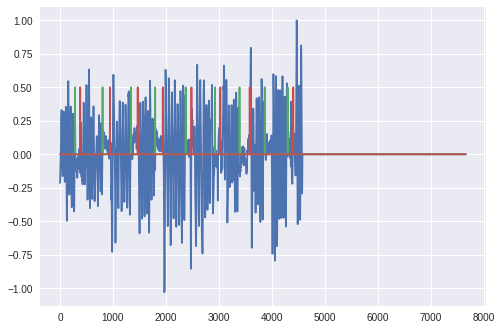

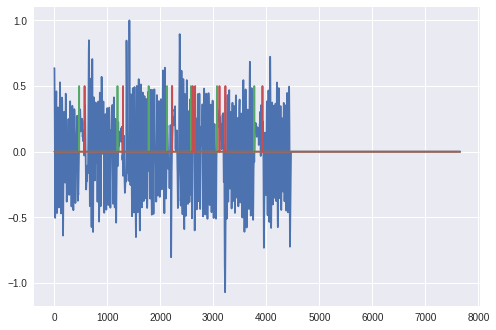

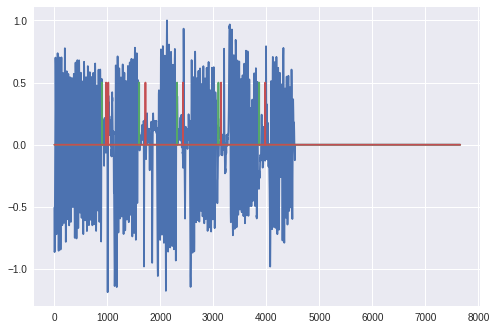

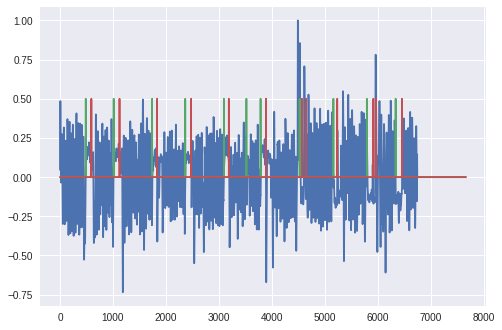

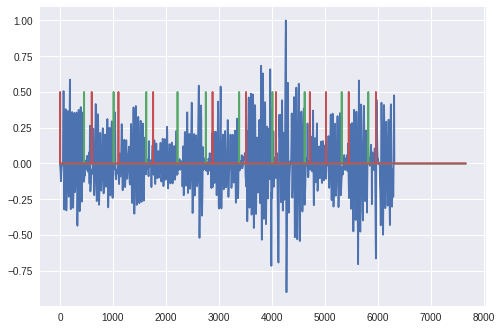

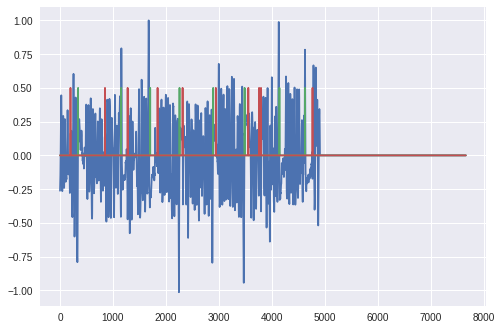

In [0]:
for k in range(np.shape(X_dev_list[0])[0]):
  mid1, mid2, _, _ = predictor_mid((X_dev_list[0])[k:k+1, :, :], model1_list[], model2)
  plt.plot(X_dev[k])
  plt.plot(mid1)
  plt.plot(mid2)
  plt.show()

In [0]:
model1_list[0].summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_19 (InputLayer)        (None, 7657, 1)           0         
_________________________________________________________________
conv1d_19 (Conv1D)           (None, 1911, 128)         2176      
_________________________________________________________________
batch_normalization_37 (Batc (None, 1911, 128)         512       
_________________________________________________________________
activation_5 (Activation)    (None, 1911, 128)         0         
_________________________________________________________________
dropout_37 (Dropout)         (None, 1911, 128)         0         
_________________________________________________________________
bidirectional_19 (Bidirectio (None, 1911, 128)         99328     
_________________________________________________________________
batch_normalization_38 (Batc (None, 1911, 128)         512       
__________

**VALIDATION**

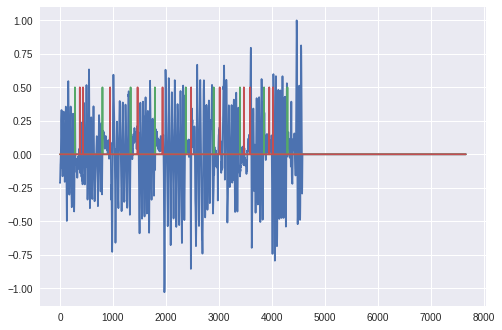

/usr/local/lib/python3.6/dist-packages/numpy/core/_methods.py:135: RuntimeWarning: Degrees of freedom <= 0 for slice
  keepdims=keepdims)
/usr/local/lib/python3.6/dist-packages/numpy/core/_methods.py:105: RuntimeWarning: invalid value encountered in true_divide
  arrmean, rcount, out=arrmean, casting='unsafe', subok=False)
/usr/local/lib/python3.6/dist-packages/numpy/core/_methods.py:127: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


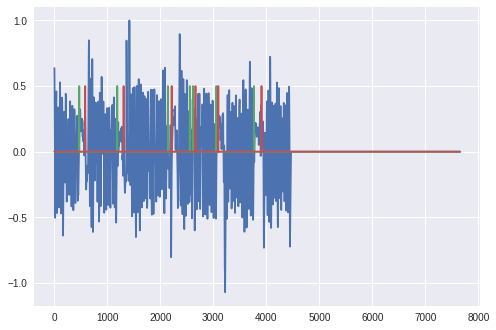

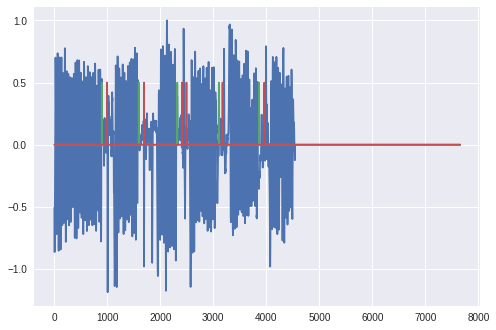

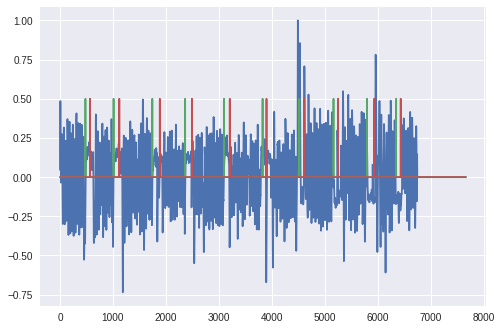

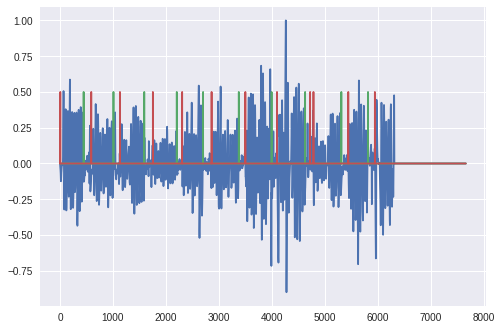

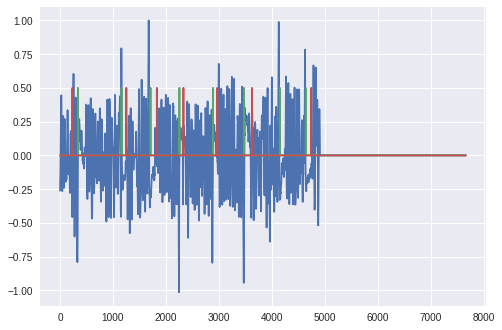

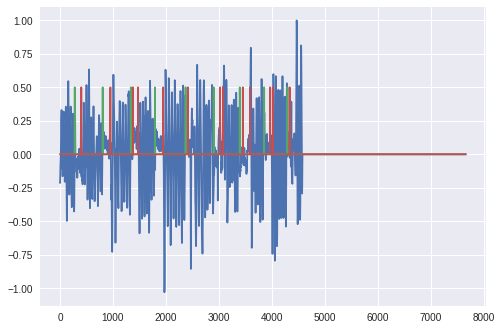

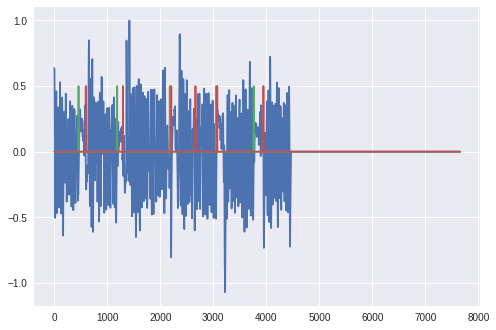

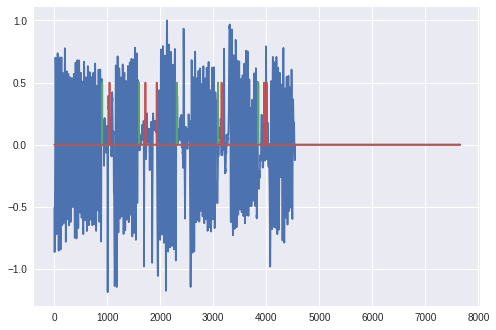

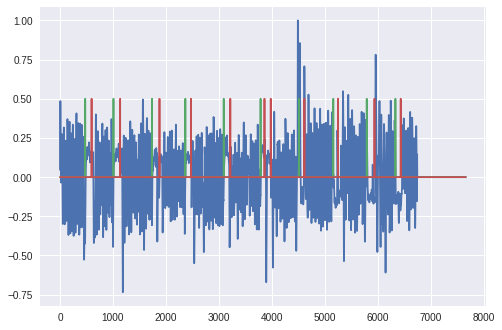

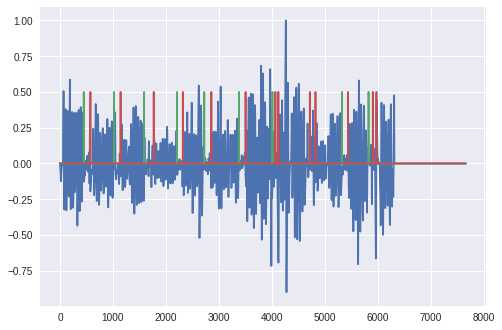

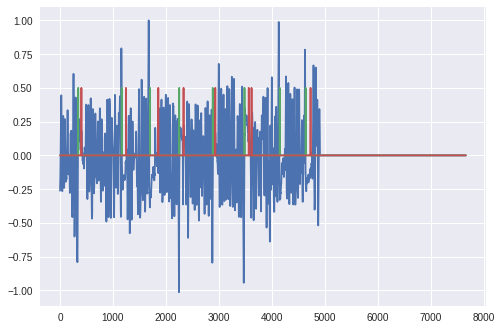

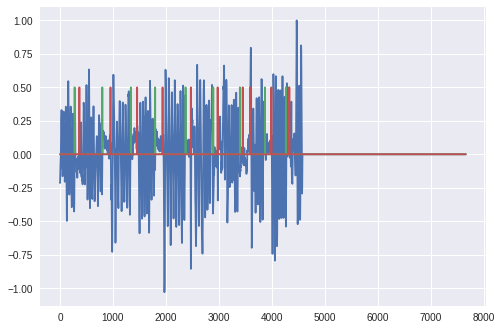

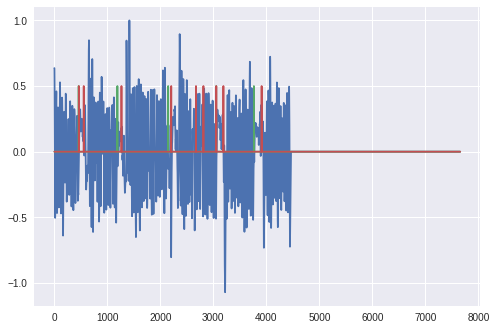

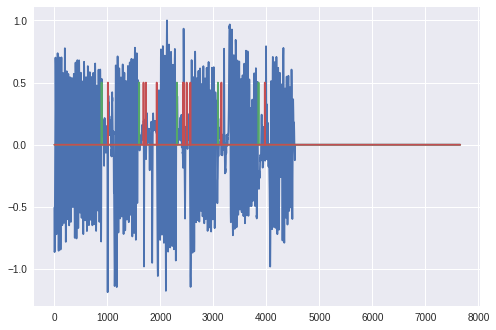

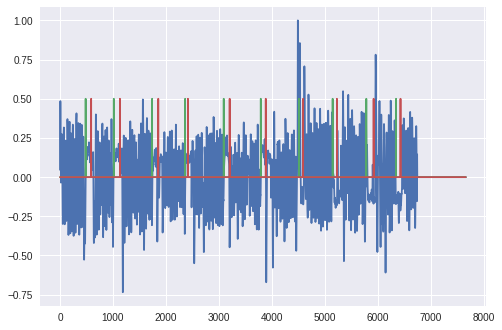

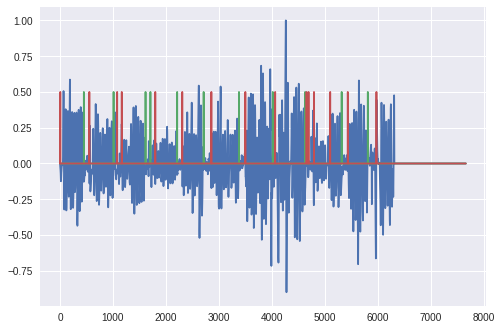

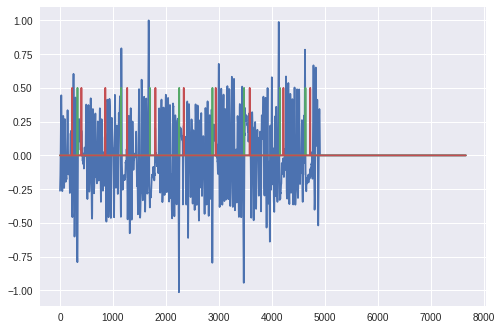

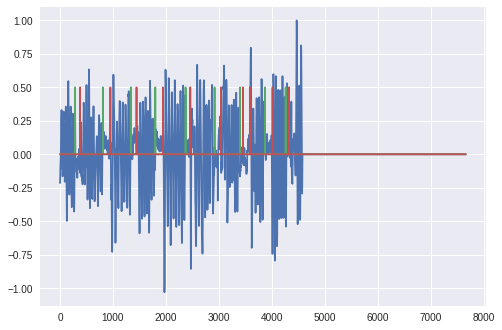

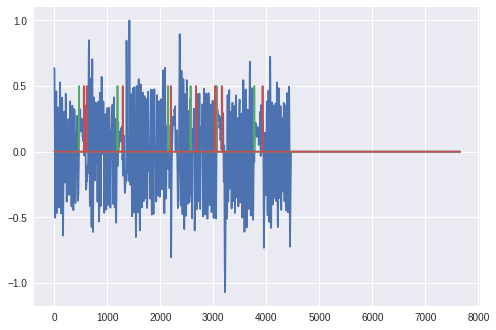

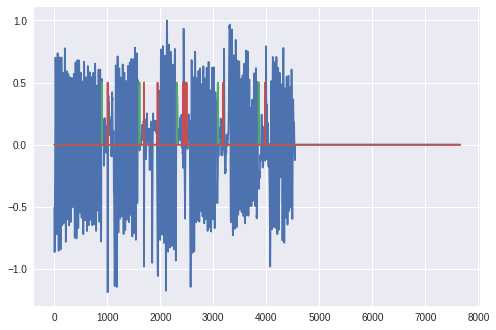

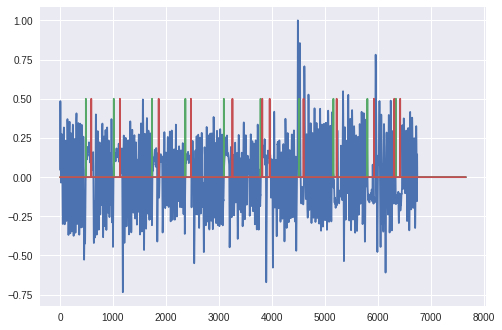

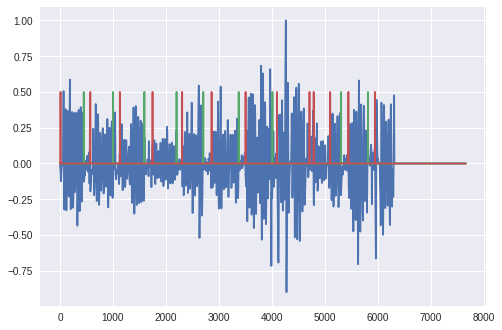

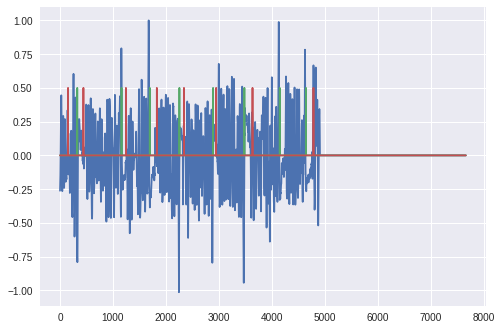

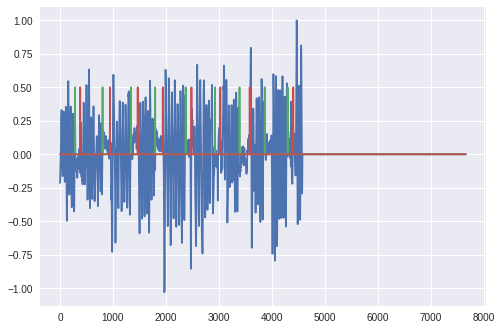

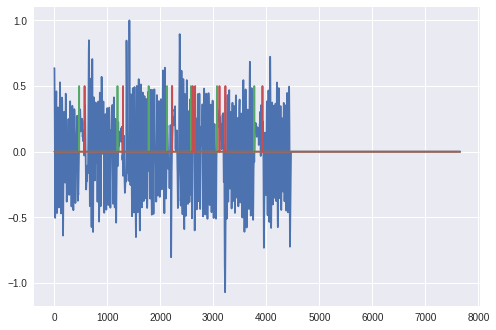

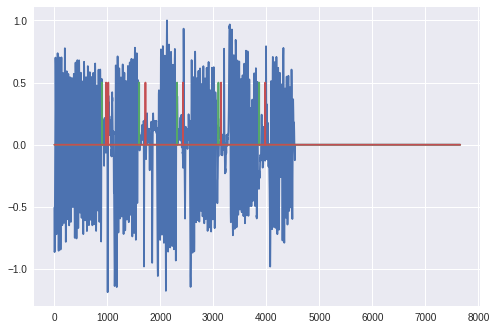

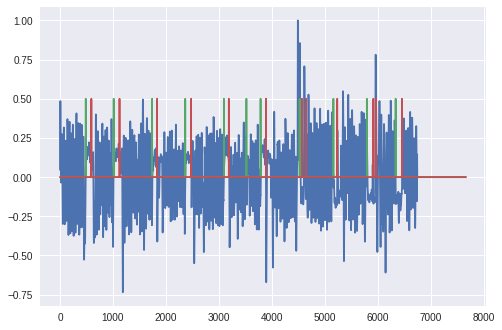

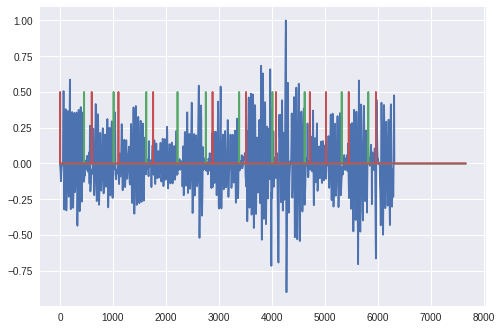

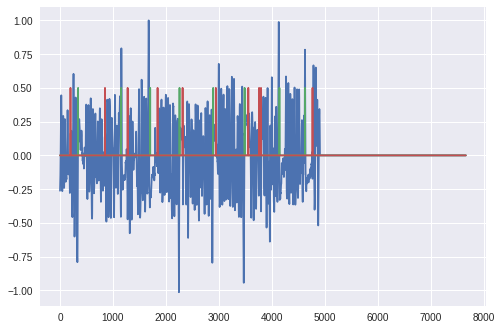

In [0]:
aa = 0
tpp = 0
fnn = 0
fpp = 0
ss = 0
for i in range(5):
  a = 0
  tp = 0
  fn = 0
  fp = 0
  s = 0
  for j in range(6):
    n, nn, mid1, mid2 = predictor_mid((X_dev_list[i])[j:j+1, :, :], model1_list[i], model2_list[i])
    plt.plot(((X_dev_list[i])[j:j+1, :, :])[0])
    plt.plot(n)
    plt.plot(nn)
    plt.show()
    (Y_dev1_list[i])[j].reshape(1, -1)
    (Y_dev2_list[i])[j].reshape(1, -1)    
#     print(np.shape((Y_dev2_list[i])[j]))
    ydev = np.concatenate(((Y_dev1_list[i])[j], (Y_dev2_list[i])[j]))
    mid = np.concatenate((mid1, mid2))
    flags = np.zeros(np.size(ydev))
    dist = []
    true_pos = 0
    false_pos = 0
    false_neg = 0
    correct_detection = 0
    
    for k in range(np.size(mid)):
      for h in range(np.size(ydev)):
        if(abs(mid[k] - ydev[h])) <= 50:
          if flags[h] == 0:
            flags[h] += 1
            dist.append(abs(mid[k] - ydev[h]))
            true_pos += 1
#             print(k, h)
#             print(mid[k])
#             print(ydev[h])
#             print("----")
          else:
            flags[h] += 1
            false_pos += 1
          continue
      false_pos += 1
#       print(i, j, "true_pos: ", true_pos)
#       print(i, j, "false_pos: ", false_pos)
    
#     for k in range(np.size(mid2)):
#       for h in range(np.size(ydev)):
#         if(abs(mid2[k] - ydev[h])) <= 50:
#           if flags[h] == 0:
#             flags[h] += 1
#             dist.append(abs(mid1[h] - ydev[h]))
#             true_pos += 1
#           else:
#             flags[h] += 1
#             false_pos += 1
#           continue
#       false_pos += 1
    
    for k in range(np.size(flags)):
      if(flags[k] == 0):
        false_neg += 1
      if(flags[k] == 1):
        correct_detection += 1
    
    accuracy = correct_detection/np.size(flags)
    std_dev = np.std(np.array(dist))
    
    a += accuracy
    tp += true_pos
    fn += false_neg
    fp += false_pos
    s += std_dev
  a = a/6
  tp = tp/6
  fn = fn/6
  fp = fp/6
  s = s/6
  aa += a
  tpp += tp
  fnn += fn
  fpp += fp
  ss += s
#   print("Accuracy for this validation set: ", a)
#   print("Standard Deviation: ", s)
#   print("True pos: ", tp)
#   print("False neg: ", fn)
#   print("False pos: ", fp)
#   print("-----")
# print("------------------------")
# print("Net Accuracy: ", aa/5)
# print("Net True Pos: ", tpp/5)
# print("Net False neg: ", fnn/5)
# print("Net False Pos: ", fpp/5)
# print("Net Standard Deviation: ", ss/5)
# model1_list[i].summary